In [36]:
import os
import sys
from nltk.corpus import stopwords
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [37]:
from pyspark.sql import SparkSession, SQLContext
import os
import pyspark.sql.functions as f
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()

In [38]:
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

In [39]:
classics = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_clean.csv"))

In [40]:
classics.show()

+----+----+--------------------+
|  id|type|                text|
+----+----+--------------------+
|1905|   C| the governess or...|
| 768|   C| transcribed from...|
|1342|   C| pride and prejud...|
|1260|   C| transcribed from...|
| 514|   C| little women by ...|
| 113|   C| in honor of lisa...|
| 145|   C| middlemarch by g...|
|  45|   C| anne of green ga...|
+----+----+--------------------+



In [41]:
import string

In [42]:
classics_df = classics.withColumn('line', f.explode(f.split(f.col('text'), '\n')))
classics_df.show()

+----+----+--------------------+--------------------+
|  id|type|                text|                line|
+----+----+--------------------+--------------------+
|1905|   C| the governess or...| the governess or...|
| 768|   C| transcribed from...| transcribed from...|
|1342|   C| pride and prejud...| pride and prejud...|
|1260|   C| transcribed from...| transcribed from...|
| 514|   C| little women by ...| little women by ...|
| 113|   C| in honor of lisa...| in honor of lisa...|
| 145|   C| middlemarch by g...| middlemarch by g...|
|  45|   C| anne of green ga...| anne of green ga...|
+----+----+--------------------+--------------------+



In [43]:
classics = classics_df.rdd.map(lambda x : x['line']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = classics                                                  \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

In [48]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [49]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [50]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/10 20:59:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/10 20:59:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [51]:
classics_df.printSchema()
classics_df.show()

root
 |-- id: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- text: string (nullable = true)
 |-- line: string (nullable = true)

+----+----+--------------------+--------------------+
|  id|type|                text|                line|
+----+----+--------------------+--------------------+
|1905|   C| the governess or...| the governess or...|
| 768|   C| transcribed from...| transcribed from...|
|1342|   C| pride and prejud...| pride and prejud...|
|1260|   C| transcribed from...| transcribed from...|
| 514|   C| little women by ...| little women by ...|
| 113|   C| in honor of lisa...| in honor of lisa...|
| 145|   C| middlemarch by g...| middlemarch by g...|
|  45|   C| anne of green ga...| anne of green ga...|
+----+----+--------------------+--------------------+



In [52]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[1017, 398, 1829,...|[0.02705942339036...|
|    1|[103, 45, 51, 154...|[0.03826039449968...|
|    2|[181, 242, 251, 9...|[0.03636879194068...|
|    3|[233, 249, 633, 7...|[0.06018744031122...|
|    4|[45, 51, 233, 94,...|[0.00582230147525...|
|    5|[149, 189, 482, 6...|[0.07171151029948...|
|    6|[61, 22, 212, 140...|[0.05561179233230...|
|    7|[51, 45, 94, 107,...|[0.01875640883499...|
|    8|[45, 94, 51, 107,...|[0.01852759416183...|
|    9|[1017, 398, 1870,...|[0.00583070334329...|
+-----+--------------------+--------------------+



/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [53]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

In [54]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[1017, 398, 1829,...|[0.02705942339036...|[teachum, jenny, ...|
|    1|[103, 45, 51, 154...|[0.03826039449968...|[laurie, lydgate,...|
|    2|[181, 242, 251, 9...|[0.03636879194068...|[darcy, bennet, b...|
|    3|[233, 249, 633, 7...|[0.06018744031122...|[colin, dickon, m...|
|    4|[45, 51, 233, 94,...|[0.00582230147525...|[lydgate, dorothe...|
|    5|[149, 189, 482, 6...|[0.07171151029948...|[heathcliff, lint...|
|    6|[61, 22, 212, 140...|[0.05561179233230...|[marilla, anne, m...|
|    7|[51, 45, 94, 107,...|[0.01875640883499...|[dorothea, lydgat...|
|    8|[45, 94, 51, 107,...|[0.01852759416183...|[lydgate, casaubo...|
|    9|[1017, 398, 1870,...|[0.00583070334329...|[teachum, jenny, ...|
+-----+--------------------+--------------------+--------------------+



In [55]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[1017, 398, 1829,...|[0.02705942339036...|teachum jenny cae...|
|    1|[103, 45, 51, 154...|[0.03826039449968...|laurie lydgate do...|
|    2|[181, 242, 251, 9...|[0.03636879194068...|darcy bennet bing...|
|    3|[233, 249, 633, 7...|[0.06018744031122...|colin dickon medl...|
|    4|[45, 51, 233, 94,...|[0.00582230147525...|lydgate dorothea ...|
|    5|[149, 189, 482, 6...|[0.07171151029948...|heathcliff linton...|
|    6|[61, 22, 212, 140...|[0.05561179233230...|marilla anne matt...|
|    7|[51, 45, 94, 107,...|[0.01875640883499...|dorothea lydgate ...|
|    8|[45, 94, 51, 107,...|[0.01852759416183...|lydgate casaubon ...|
|    9|[1017, 398, 1870,...|[0.00583070334329...|teachum jenny suk...|
+-----+--------------------+--------------------+--------------------+



In [58]:
counts = lda_topics_mapped.withColumn('word', f.explode(f.split(f.col('topic_desc'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [59]:
counts.show()

+-----------+-----+
|       word|count|
+-----------+-----+
|    lydgate|    4|
|   casaubon|    4|
|   dorothea|    4|
|      garth|    4|
|  bulstrode|    4|
|   rosamond|    3|
|      celia|    3|
|       hebe|    2|
|middlemarch|    2|
|   benefico|    2|
|      sukey|    2|
|    rozella|    2|
|     dickon|    2|
|      fidus|    2|
|    teachum|    2|
|     caelia|    2|
|       anne|    2|
| heathcliff|    2|
|      vincy|    2|
|     mignon|    2|
+-----------+-----+
only showing top 20 rows



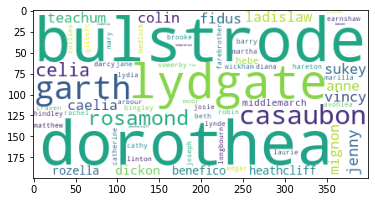

In [60]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*counts.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()
